In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
with open('df_scaled_UTD.pickle','rb') as f:
    df_scaled = pickle.load(f)
with open('sector.pickle','rb') as f:
    sector = pickle.load(f)

In [4]:
from sklearn.model_selection import train_test_split
X_train_dic = {}
X_test_dic={}
y_train_dic = {}
y_test_dic = {}
#모델이 각 업종마다 존재한다. 18개
for sector_name, df in df_scaled.items():
    # 단 셔플 없이 분할
    X_train, X_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)
    X_train_dic[sector_name] = X_train
    X_test_dic[sector_name] = X_test
    y_train_dic[sector_name] = y_train
    y_test_dic[sector_name] = y_test

In [5]:
X_train_dic['Food'].shape, y_train_dic['Food'].shape

((2400, 4), (2400,))

In [6]:
X_test_dic['Food'].shape, y_test_dic['Food'].shape

((600, 4), (600,))

# 윈도우 데이터 셋 생성

In [7]:
# 윈도우 데이터셋 생성 함수
def windowed_dataset(X, y, X_size, y_size, X_shift, y_shift, X_stride, y_stride, batch_size):
    
    # numpy array x(input)를 Dataset으로 변환
    ds_x = tf.data.Dataset.from_tensor_slices(X)
    
    #윈도우셋 구성
    ds_x = ds_x.window(size=X_size,stride=X_stride, shift=X_shift, drop_remainder=True)
    #한 차원 줄야사 반환
    ds_x = ds_x.flat_map(lambda x: x.batch(X_size))
    
    ds_y = tf.data.Dataset.from_tensor_slices(y)
    ds_y = ds_y.window(size=y_size, stride=y_stride, shift=y_shift, drop_remainder=True)
    ds_y = ds_y.flat_map(lambda y: y.batch(y_size))
    
    #같은 인덱스에 있는 애들 끼리 묶기
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    
    return ds.batch(batch_size).prefetch(1)

## 파라미터 지정

In [8]:
#윈도우 사이즈
WINDOW_SIZE = 10
# X에 대한 윈도우 함수 설정값
X_size = WINDOW_SIZE
X_shift = 10
X_stride = 1
# y에 대한 윈도우 함수 설정값
y_size = 1
y_shift = WINDOW_SIZE
y_stride = 1

batch_size = 1

In [9]:
tf_dataset_train_dic={}
for sector_name, X_train in X_train_dic.items():
    y_train = y_train_dic[sector_name]
    tf_dataset_train_dic[sector_name] = windowed_dataset(X_train,y_train[WINDOW_SIZE:], X_size, y_size,
                                X_shift, y_shift, X_stride, y_stride, batch_size)

tf_dataset_test_dic = {}
for sector_name, X_test in X_test_dic.items():
    y_test = y_test_dic[sector_name]
    tf_dataset_test_dic[sector_name] = windowed_dataset(X_test,y_test[WINDOW_SIZE:], X_size, y_size,
                                X_shift, y_shift, X_stride, y_stride, batch_size)

    # 데이터 shape, 미리보기로 체크
for x, y in tf_dataset_train_dic['Food'].take(3):
    print('X:', x.shape)
    print(x)
    print()
    print('Y:', y.shape)
    print(y)
    print('-'*100)

X: (1, 10, 4)
tf.Tensor(
[[[0.01920244 0.06794263 0.05187154 0.1027709 ]
  [0.03917412 0.06308562 0.04437396 0.07655971]
  [0.04225737 0.05670212 0.0438025  0.08195749]
  [0.06395201 0.05739598 0.04494543 0.08973443]
  [0.03599058 0.06502842 0.04208812 0.095426  ]
  [0.02599399 0.07682402 0.05366021 0.10291491]
  [0.02091734 0.06884187 0.0487285  0.10399217]
  [0.0379419  0.0818198  0.05966055 0.10730457]
  [0.01763888 0.07952729 0.05323161 0.10298404]
  [0.01986691 0.05850615 0.03965941 0.09629011]]], shape=(1, 10, 4), dtype=float64)

Y: (1, 1)
tf.Tensor([[0.075545]], shape=(1, 1), dtype=float64)
----------------------------------------------------------------------------------------------------
X: (1, 10, 4)
tf.Tensor(
[[[0.01642815 0.06356854 0.03887079 0.09088657]
  [0.01617651 0.05857276 0.03865935 0.09304683]
  [0.02629668 0.06148697 0.04708841 0.09773028]
  [0.03018051 0.06891403 0.05023144 0.10104269]
  [0.02009616 0.07196701 0.05437454 0.10910767]
  [0.00832109 0.07751787 0.05

## 모델

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
model_dic ={}
for sector_name in sector.keys():
    model_dic[sector_name] = Sequential([
        # 1차원 feature map 생성
        Conv1D(filters=32, kernel_size=5,
               padding="causal",
               activation="relu",
               #feature의 개수 3개
               input_shape=[WINDOW_SIZE, 4]),
        # LSTM
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1),
    ])

In [12]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
for sector_model in model_dic.values():
    sector_model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [13]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
# val_loss 기준 체크포인터도 생성합니다.
filename_dic={}
for sector_name in sector.keys():
    filename_dic[sector_name] = os.path.join('Models', sector_name+'ckeckpointer.ckpt')

In [15]:
#체크포인트를 저장    
mc_dic = {}
for sector_name in filename_dic:
    mc_dic[sector_name] = ModelCheckpoint(filename_dic[sector_name], 
                         save_weights_only=True, 
                         save_best_only=True, 
                         monitor='val_loss', 
                         verbose=1)

In [16]:
history_dic={}
# 학습+저장
for sector_name, train_data in tf_dataset_train_dic.items():
    test_data = tf_dataset_test_dic[sector_name]
    history = model_dic[sector_name].fit(train_data, 
                        validation_data=(test_data), 
                        epochs=50, 
                        callbacks=[mc_dic[sector_name], earlystopping])
    history_dic[sector_name] = history
with open('history_dic.pickle', 'wb') as f:
    pickle.dump(history_dic,f)

Epoch 1/50
    239/Unknown - 4s 4ms/step - loss: 0.0021 - mse: 0.0043
Epoch 1: val_loss improved from inf to 0.00443, saving model to Models\Foodckeckpointer.ckpt
239/239 [==============================] - 6s 12ms/step - loss: 0.0021 - mse: 0.0043 - val_loss: 0.0044 - val_mse: 0.0089
Epoch 2/50
229/239 [===========================>..] - ETA: 0s - loss: 9.1906e-04 - mse: 0.0018
Epoch 2: val_loss improved from 0.00443 to 0.00296, saving model to Models\Foodckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 8.8772e-04 - mse: 0.0018 - val_loss: 0.0030 - val_mse: 0.0059
Epoch 3/50
236/239 [============================>.] - ETA: 0s - loss: 7.9466e-04 - mse: 0.0016
Epoch 3: val_loss improved from 0.00296 to 0.00258, saving model to Models\Foodckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 7.8582e-04 - mse: 0.0016 - val_loss: 0.0026 - val_mse: 0.0052
Epoch 4/50
232/239 [============================>.] - ETA: 0s - loss: 7.2193e-04 

239/239 [==============================] - 1s 5ms/step - loss: 6.2385e-04 - mse: 0.0012 - val_loss: 9.2048e-04 - val_mse: 0.0018
Epoch 28/50
239/239 [==============================] - ETA: 0s - loss: 6.6089e-04 - mse: 0.0013
Epoch 28: val_loss did not improve from 0.00050
239/239 [==============================] - 1s 5ms/step - loss: 6.6089e-04 - mse: 0.0013 - val_loss: 5.4683e-04 - val_mse: 0.0011
Epoch 29/50
235/239 [============================>.] - ETA: 0s - loss: 6.3325e-04 - mse: 0.0013
Epoch 29: val_loss did not improve from 0.00050
239/239 [==============================] - 1s 5ms/step - loss: 6.2378e-04 - mse: 0.0012 - val_loss: 5.1311e-04 - val_mse: 0.0010
Epoch 30/50
239/239 [==============================] - ETA: 0s - loss: 6.1549e-04 - mse: 0.0012
Epoch 30: val_loss improved from 0.00050 to 0.00049, saving model to Models\Foodckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.1549e-04 - mse: 0.0012 - val_loss: 4.8729e-04 - val_mse: 9.7459e-0

Epoch 4/50
231/239 [===========================>..] - ETA: 0s - loss: 6.6567e-04 - mse: 0.0013
Epoch 4: val_loss improved from 0.04838 to 0.04538, saving model to Models\Clothingckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.6992e-04 - mse: 0.0013 - val_loss: 0.0454 - val_mse: 0.0908
Epoch 5/50
228/239 [===========================>..] - ETA: 0s - loss: 4.8270e-04 - mse: 9.6539e-04
Epoch 5: val_loss improved from 0.04538 to 0.04375, saving model to Models\Clothingckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.8899e-04 - mse: 9.7798e-04 - val_loss: 0.0438 - val_mse: 0.0875
Epoch 6/50
230/239 [===========================>..] - ETA: 0s - loss: 3.8137e-04 - mse: 7.6274e-04
Epoch 6: val_loss improved from 0.04375 to 0.04312, saving model to Models\Clothingckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.8770e-04 - mse: 7.7540e-04 - val_loss: 0.0431 - val_mse: 0.0862
Epoch 7/50
229/239 [=

Epoch 30/50
233/239 [============================>.] - ETA: 0s - loss: 2.4836e-04 - mse: 4.9673e-04
Epoch 30: val_loss improved from 0.03378 to 0.03348, saving model to Models\Clothingckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.4826e-04 - mse: 4.9652e-04 - val_loss: 0.0335 - val_mse: 0.0670
Epoch 31/50
233/239 [============================>.] - ETA: 0s - loss: 2.4472e-04 - mse: 4.8944e-04
Epoch 31: val_loss improved from 0.03348 to 0.03320, saving model to Models\Clothingckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.4470e-04 - mse: 4.8940e-04 - val_loss: 0.0332 - val_mse: 0.0664
Epoch 32/50
232/239 [============================>.] - ETA: 0s - loss: 2.4298e-04 - mse: 4.8596e-04
Epoch 32: val_loss improved from 0.03320 to 0.03288, saving model to Models\Clothingckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.4189e-04 - mse: 4.8379e-04 - val_loss: 0.0329 - val_mse: 0.0658
Epoch 3

229/239 [===========================>..] - ETA: 0s - loss: 6.4254e-04 - mse: 0.0013   
Epoch 5: val_loss improved from 0.02055 to 0.01937, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.2596e-04 - mse: 0.0013 - val_loss: 0.0194 - val_mse: 0.0387
Epoch 6/50
231/239 [===========================>..] - ETA: 0s - loss: 5.5949e-04 - mse: 0.0011   
Epoch 6: val_loss improved from 0.01937 to 0.01834, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.5011e-04 - mse: 0.0011 - val_loss: 0.0183 - val_mse: 0.0367
Epoch 7/50
229/239 [===========================>..] - ETA: 0s - loss: 5.2689e-04 - mse: 0.0011    
Epoch 7: val_loss improved from 0.01834 to 0.01748, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.1469e-04 - mse: 0.0010 - val_loss: 0.0175 - val_mse: 0.0350
Epoch 8/50
232/239 [==================

Epoch 30/50
232/239 [============================>.] - ETA: 0s - loss: 2.5576e-04 - mse: 5.1152e-04
Epoch 30: val_loss improved from 0.00871 to 0.00835, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.5368e-04 - mse: 5.0737e-04 - val_loss: 0.0084 - val_mse: 0.0167
Epoch 31/50
238/239 [============================>.] - ETA: 0s - loss: 2.4768e-04 - mse: 4.9536e-04
Epoch 31: val_loss improved from 0.00835 to 0.00797, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.4731e-04 - mse: 4.9462e-04 - val_loss: 0.0080 - val_mse: 0.0159
Epoch 32/50
228/239 [===========================>..] - ETA: 0s - loss: 2.4196e-04 - mse: 4.8392e-04
Epoch 32: val_loss improved from 0.00797 to 0.00756, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.4154e-04 - mse: 4.8307e-04 - val_loss: 0.0076 - val_mse: 0.0151
Epoch 3

Epoch 6/50
229/239 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.0023   
Epoch 6: val_loss improved from 0.02088 to 0.01919, saving model to Models\Medicineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0011 - mse: 0.0023 - val_loss: 0.0192 - val_mse: 0.0384
Epoch 7/50
232/239 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0021     
Epoch 7: val_loss improved from 0.01919 to 0.01708, saving model to Models\Medicineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 0.0171 - val_mse: 0.0342
Epoch 8/50
229/239 [===========================>..] - ETA: 0s - loss: 6.8323e-04 - mse: 0.0014  
Epoch 8: val_loss improved from 0.01708 to 0.01628, saving model to Models\Medicineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.7877e-04 - mse: 0.0014 - val_loss: 0.0163 - val_mse: 0.0326
Epoch 9/50
228/239 [=======================

Epoch 12/50
233/239 [============================>.] - ETA: 0s - loss: 2.5617e-04 - mse: 5.1235e-04
Epoch 12: val_loss improved from 0.03201 to 0.03135, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.5108e-04 - mse: 5.0216e-04 - val_loss: 0.0313 - val_mse: 0.0627
Epoch 13/50
234/239 [============================>.] - ETA: 0s - loss: 2.4493e-04 - mse: 4.8986e-04
Epoch 13: val_loss improved from 0.03135 to 0.03045, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.4124e-04 - mse: 4.8247e-04 - val_loss: 0.0304 - val_mse: 0.0609
Epoch 14/50
237/239 [============================>.] - ETA: 0s - loss: 2.3625e-04 - mse: 4.7250e-04
Epoch 14: val_loss improved from 0.03045 to 0.03013, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.3508e-04 - mse: 4.7016e-04 - val_loss: 0.0301 - val_mse: 0.0603
Epoc

Epoch 37/50
231/239 [===========================>..] - ETA: 0s - loss: 1.9206e-04 - mse: 3.8411e-04
Epoch 37: val_loss improved from 0.02139 to 0.02095, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.8751e-04 - mse: 3.7501e-04 - val_loss: 0.0209 - val_mse: 0.0419
Epoch 38/50
237/239 [============================>.] - ETA: 0s - loss: 1.8626e-04 - mse: 3.7251e-04
Epoch 38: val_loss improved from 0.02095 to 0.02057, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.8539e-04 - mse: 3.7078e-04 - val_loss: 0.0206 - val_mse: 0.0411
Epoch 39/50
235/239 [============================>.] - ETA: 0s - loss: 1.8530e-04 - mse: 3.7059e-04
Epoch 39: val_loss improved from 0.02057 to 0.02037, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.8356e-04 - mse: 3.6711e-04 - val_loss: 0.0204 - val_mse: 0.0407
Epoc

232/239 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 0.0021
Epoch 13: val_loss did not improve from 0.00054
239/239 [==============================] - 1s 5ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 6.7893e-04 - val_mse: 0.0014
Epoch 14/50
232/239 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 0.0020
Epoch 14: val_loss did not improve from 0.00054
239/239 [==============================] - 1s 5ms/step - loss: 9.7964e-04 - mse: 0.0020 - val_loss: 6.8487e-04 - val_mse: 0.0014
Epoch 15/50
235/239 [============================>.] - ETA: 0s - loss: 9.4831e-04 - mse: 0.0019
Epoch 15: val_loss did not improve from 0.00054
239/239 [==============================] - 1s 5ms/step - loss: 9.3765e-04 - mse: 0.0019 - val_loss: 6.8845e-04 - val_mse: 0.0014
Epoch 16/50
238/239 [============================>.] - ETA: 0s - loss: 8.9990e-04 - mse: 0.0018
Epoch 16: val_loss did not improve from 0.00054
239/239 [==============================] - 1s 5ms/step - loss

239/239 [==============================] - 5s 7ms/step - loss: 3.5960e-04 - mse: 7.1920e-04 - val_loss: 0.0701 - val_mse: 0.1402
Epoch 2/50
237/239 [============================>.] - ETA: 0s - loss: 2.7786e-04 - mse: 5.5571e-04
Epoch 2: val_loss improved from 0.07008 to 0.06595, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.8037e-04 - mse: 5.6075e-04 - val_loss: 0.0659 - val_mse: 0.1319
Epoch 3/50
236/239 [============================>.] - ETA: 0s - loss: 2.2057e-04 - mse: 4.4113e-04
Epoch 3: val_loss improved from 0.06595 to 0.06450, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.2286e-04 - mse: 4.4573e-04 - val_loss: 0.0645 - val_mse: 0.1290
Epoch 4/50
236/239 [============================>.] - ETA: 0s - loss: 1.6919e-04 - mse: 3.3838e-04
Epoch 4: val_loss improved from 0.06450 to 0.06211, saving model to Models\Electronicckeckpointer.ckpt
239/239

233/239 [============================>.] - ETA: 0s - loss: 4.2757e-05 - mse: 8.5515e-05
Epoch 26: val_loss improved from 0.01730 to 0.01662, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.3967e-05 - mse: 8.7934e-05 - val_loss: 0.0166 - val_mse: 0.0332
Epoch 27/50
237/239 [============================>.] - ETA: 0s - loss: 4.2727e-05 - mse: 8.5455e-05
Epoch 27: val_loss improved from 0.01662 to 0.01594, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.3408e-05 - mse: 8.6816e-05 - val_loss: 0.0159 - val_mse: 0.0319
Epoch 28/50
236/239 [============================>.] - ETA: 0s - loss: 4.2193e-05 - mse: 8.4387e-05
Epoch 28: val_loss improved from 0.01594 to 0.01563, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.2577e-05 - mse: 8.5154e-05 - val_loss: 0.0156 - val_mse: 0.0313
Epoch 29/50
2

Epoch 2/50
232/239 [============================>.] - ETA: 0s - loss: 0.0031 - mse: 0.0062
Epoch 2: val_loss improved from 0.00156 to 0.00111, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0030 - mse: 0.0061 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 3/50
239/239 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0047
Epoch 3: val_loss improved from 0.00111 to 0.00077, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0024 - mse: 0.0047 - val_loss: 7.7461e-04 - val_mse: 0.0015
Epoch 4/50
232/239 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0039
Epoch 4: val_loss improved from 0.00077 to 0.00058, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0019 - mse: 0.0038 - val_loss: 5.8013e-04 - val_mse: 0.0012
Epoch 5/50
228/239 [=====================

Epoch 27/50
231/239 [===========================>..] - ETA: 0s - loss: 5.2098e-04 - mse: 0.0010
Epoch 27: val_loss improved from 0.00021 to 0.00021, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.0823e-04 - mse: 0.0010 - val_loss: 2.1361e-04 - val_mse: 4.2723e-04
Epoch 28/50
228/239 [===========================>..] - ETA: 0s - loss: 5.1180e-04 - mse: 0.0010
Epoch 28: val_loss improved from 0.00021 to 0.00021, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.9347e-04 - mse: 9.8693e-04 - val_loss: 2.1243e-04 - val_mse: 4.2486e-04
Epoch 29/50
233/239 [============================>.] - ETA: 0s - loss: 4.8639e-04 - mse: 9.7278e-04
Epoch 29: val_loss improved from 0.00021 to 0.00021, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.7813e-04 - mse: 9.5626e-04 - val_loss: 2.1119e-04 - val

    229/Unknown - 4s 4ms/step - loss: 0.0304 - mse: 0.0607
Epoch 1: val_loss improved from inf to 0.00583, saving model to Models\Transportckeckpointer.ckpt
239/239 [==============================] - 5s 7ms/step - loss: 0.0291 - mse: 0.0582 - val_loss: 0.0058 - val_mse: 0.0117
Epoch 2/50
230/239 [===========================>..] - ETA: 0s - loss: 0.0108 - mse: 0.0217
Epoch 2: val_loss improved from 0.00583 to 0.00284, saving model to Models\Transportckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0104 - mse: 0.0209 - val_loss: 0.0028 - val_mse: 0.0057
Epoch 3/50
235/239 [============================>.] - ETA: 0s - loss: 0.0054 - mse: 0.0108
Epoch 3: val_loss improved from 0.00284 to 0.00190, saving model to Models\Transportckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0053 - mse: 0.0106 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 4/50
231/239 [===========================>..] - ETA: 0s - loss: 0.0025 - mse: 0.0051
Epo

238/239 [============================>.] - ETA: 0s - loss: 5.4704e-04 - mse: 0.0011
Epoch 26: val_loss improved from 0.00009 to 0.00009, saving model to Models\Transportckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.4493e-04 - mse: 0.0011 - val_loss: 8.9629e-05 - val_mse: 1.7926e-04
Epoch 27/50
232/239 [============================>.] - ETA: 0s - loss: 5.5050e-04 - mse: 0.0011
Epoch 27: val_loss did not improve from 0.00009
239/239 [==============================] - 1s 5ms/step - loss: 5.3486e-04 - mse: 0.0011 - val_loss: 9.1569e-05 - val_mse: 1.8314e-04
Epoch 28/50
235/239 [============================>.] - ETA: 0s - loss: 5.3946e-04 - mse: 0.0011
Epoch 28: val_loss improved from 0.00009 to 0.00009, saving model to Models\Transportckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.3084e-04 - mse: 0.0011 - val_loss: 8.7539e-05 - val_mse: 1.7508e-04
Epoch 29/50
229/239 [===========================>..] - ETA: 0s - loss: 

Epoch 9/50
239/239 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0059
Epoch 9: val_loss did not improve from 0.00016
239/239 [==============================] - 1s 5ms/step - loss: 0.0030 - mse: 0.0059 - val_loss: 1.5873e-04 - val_mse: 3.1746e-04
Epoch 10/50
239/239 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0069
Epoch 10: val_loss did not improve from 0.00016
239/239 [==============================] - 1s 5ms/step - loss: 0.0034 - mse: 0.0069 - val_loss: 1.7160e-04 - val_mse: 3.4320e-04
Epoch 11/50
233/239 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0053
Epoch 11: val_loss did not improve from 0.00016
239/239 [==============================] - 1s 5ms/step - loss: 0.0026 - mse: 0.0052 - val_loss: 1.8137e-04 - val_mse: 3.6273e-04
Epoch 12/50
229/239 [===========================>..] - ETA: 0s - loss: 0.0021 - mse: 0.0042
Epoch 12: val_loss did not improve from 0.00016
239/239 [==============================] - 1s 5ms/step 

239/239 [==============================] - 1s 5ms/step - loss: 5.9614e-04 - mse: 0.0012 - val_loss: 0.0144 - val_mse: 0.0288
Epoch 19/50
230/239 [===========================>..] - ETA: 0s - loss: 5.8948e-04 - mse: 0.0012
Epoch 19: val_loss improved from 0.01439 to 0.01405, saving model to Models\Powerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.6877e-04 - mse: 0.0011 - val_loss: 0.0140 - val_mse: 0.0281
Epoch 20/50
231/239 [===========================>..] - ETA: 0s - loss: 5.6596e-04 - mse: 0.0011
Epoch 20: val_loss improved from 0.01405 to 0.01345, saving model to Models\Powerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.4760e-04 - mse: 0.0011 - val_loss: 0.0134 - val_mse: 0.0269
Epoch 21/50
231/239 [===========================>..] - ETA: 0s - loss: 5.4176e-04 - mse: 0.0011
Epoch 21: val_loss improved from 0.01345 to 0.01304, saving model to Models\Powerckeckpointer.ckpt
239/239 [==============================]

Epoch 44/50
236/239 [============================>.] - ETA: 0s - loss: 1.8310e-04 - mse: 3.6620e-04
Epoch 44: val_loss improved from 0.00326 to 0.00298, saving model to Models\Powerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.8099e-04 - mse: 3.6198e-04 - val_loss: 0.0030 - val_mse: 0.0060
Epoch 45/50
234/239 [============================>.] - ETA: 0s - loss: 1.7608e-04 - mse: 3.5215e-04
Epoch 45: val_loss improved from 0.00298 to 0.00286, saving model to Models\Powerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.7263e-04 - mse: 3.4526e-04 - val_loss: 0.0029 - val_mse: 0.0057
Epoch 46/50
229/239 [===========================>..] - ETA: 0s - loss: 1.7682e-04 - mse: 3.5365e-04
Epoch 46: val_loss improved from 0.00286 to 0.00259, saving model to Models\Powerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.6983e-04 - mse: 3.3966e-04 - val_loss: 0.0026 - val_mse: 0.0052
Epoch 47/50
234/

Epoch 20/50
230/239 [===========================>..] - ETA: 0s - loss: 6.5073e-04 - mse: 0.0013
Epoch 20: val_loss improved from 0.00489 to 0.00477, saving model to Models\Teleckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.3350e-04 - mse: 0.0013 - val_loss: 0.0048 - val_mse: 0.0095
Epoch 21/50
236/239 [============================>.] - ETA: 0s - loss: 6.2866e-04 - mse: 0.0013
Epoch 21: val_loss improved from 0.00477 to 0.00464, saving model to Models\Teleckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.2455e-04 - mse: 0.0012 - val_loss: 0.0046 - val_mse: 0.0093
Epoch 22/50
236/239 [============================>.] - ETA: 0s - loss: 6.1750e-04 - mse: 0.0012
Epoch 22: val_loss improved from 0.00464 to 0.00453, saving model to Models\Teleckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.1350e-04 - mse: 0.0012 - val_loss: 0.0045 - val_mse: 0.0091
Epoch 23/50
239/239 [======================

239/239 [==============================] - 1s 5ms/step - loss: 4.1588e-04 - mse: 8.3176e-04 - val_loss: 0.0024 - val_mse: 0.0047
Epoch 46/50
228/239 [===========================>..] - ETA: 0s - loss: 4.1187e-04 - mse: 8.2375e-04
Epoch 46: val_loss improved from 0.00236 to 0.00223, saving model to Models\Teleckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.9790e-04 - mse: 7.9580e-04 - val_loss: 0.0022 - val_mse: 0.0045
Epoch 47/50
238/239 [============================>.] - ETA: 0s - loss: 3.6497e-04 - mse: 7.2994e-04
Epoch 47: val_loss improved from 0.00223 to 0.00215, saving model to Models\Teleckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.6553e-04 - mse: 7.3106e-04 - val_loss: 0.0021 - val_mse: 0.0043
Epoch 48/50
237/239 [============================>.] - ETA: 0s - loss: 3.6308e-04 - mse: 7.2617e-04
Epoch 48: val_loss improved from 0.00215 to 0.00188, saving model to Models\Teleckeckpointer.ckpt
239/239 [==========

232/239 [============================>.] - ETA: 0s - loss: 9.0302e-04 - mse: 0.0018
Epoch 22: val_loss improved from 0.00105 to 0.00104, saving model to Models\Financeckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 8.9615e-04 - mse: 0.0018 - val_loss: 0.0010 - val_mse: 0.0021
Epoch 23/50
233/239 [============================>.] - ETA: 0s - loss: 8.9338e-04 - mse: 0.0018
Epoch 23: val_loss improved from 0.00104 to 0.00103, saving model to Models\Financeckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 8.8948e-04 - mse: 0.0018 - val_loss: 0.0010 - val_mse: 0.0021
Epoch 24/50
230/239 [===========================>..] - ETA: 0s - loss: 8.6236e-04 - mse: 0.0017
Epoch 24: val_loss improved from 0.00103 to 0.00102, saving model to Models\Financeckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 8.7655e-04 - mse: 0.0018 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 25/50
233/239 [=========================

230/239 [===========================>..] - ETA: 0s - loss: 5.7890e-04 - mse: 0.0012
Epoch 48: val_loss did not improve from 0.00091
239/239 [==============================] - 1s 5ms/step - loss: 5.8396e-04 - mse: 0.0012 - val_loss: 9.6564e-04 - val_mse: 0.0019
Epoch 49/50
228/239 [===========================>..] - ETA: 0s - loss: 5.9732e-04 - mse: 0.0012
Epoch 49: val_loss did not improve from 0.00091
239/239 [==============================] - 1s 5ms/step - loss: 6.0845e-04 - mse: 0.0012 - val_loss: 9.5293e-04 - val_mse: 0.0019
Epoch 50/50
230/239 [===========================>..] - ETA: 0s - loss: 5.6342e-04 - mse: 0.0011
Epoch 50: val_loss did not improve from 0.00091
239/239 [==============================] - 1s 5ms/step - loss: 5.6786e-04 - mse: 0.0011 - val_loss: 9.7133e-04 - val_mse: 0.0019
Epoch 1/50
    239/Unknown - 4s 4ms/step - loss: 0.0018 - mse: 0.0036
Epoch 1: val_loss improved from inf to 0.01089, saving model to Models\Brokerageckeckpointer.ckpt
239/239 [================

Epoch 26/50
239/239 [==============================] - ETA: 0s - loss: 3.0383e-04 - mse: 6.0766e-04
Epoch 26: val_loss did not improve from 0.00221
239/239 [==============================] - 1s 5ms/step - loss: 3.0383e-04 - mse: 6.0766e-04 - val_loss: 0.0023 - val_mse: 0.0045
Epoch 27/50
239/239 [==============================] - ETA: 0s - loss: 2.9912e-04 - mse: 5.9825e-04
Epoch 27: val_loss did not improve from 0.00221
239/239 [==============================] - 1s 5ms/step - loss: 2.9912e-04 - mse: 5.9825e-04 - val_loss: 0.0023 - val_mse: 0.0046
Epoch 28/50
239/239 [==============================] - ETA: 0s - loss: 2.9232e-04 - mse: 5.8465e-04
Epoch 28: val_loss did not improve from 0.00221
239/239 [==============================] - 1s 5ms/step - loss: 2.9232e-04 - mse: 5.8465e-04 - val_loss: 0.0024 - val_mse: 0.0047
Epoch 29/50
239/239 [==============================] - ETA: 0s - loss: 2.8651e-04 - mse: 5.7302e-04
Epoch 29: val_loss did not improve from 0.00221
239/239 [============

Epoch 19/50
230/239 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 0.0022  
Epoch 19: val_loss improved from 0.00136 to 0.00128, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 20/50
231/239 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 0.0022  
Epoch 20: val_loss improved from 0.00128 to 0.00118, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 21/50
231/239 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 0.0021  
Epoch 21: val_loss improved from 0.00118 to 0.00109, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 22/50
230/239 [===========================>..]

233/239 [============================>.] - ETA: 0s - loss: 6.6653e-04 - mse: 0.0013 
Epoch 44: val_loss improved from 0.00059 to 0.00059, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.5760e-04 - mse: 0.0013 - val_loss: 5.8675e-04 - val_mse: 0.0012
Epoch 45/50
229/239 [===========================>..] - ETA: 0s - loss: 6.3389e-04 - mse: 0.0013 
Epoch 45: val_loss did not improve from 0.00059
239/239 [==============================] - 1s 5ms/step - loss: 6.2026e-04 - mse: 0.0012 - val_loss: 6.2843e-04 - val_mse: 0.0013
Epoch 46/50
233/239 [============================>.] - ETA: 0s - loss: 6.8393e-04 - mse: 0.0014 
Epoch 46: val_loss improved from 0.00059 to 0.00057, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.7377e-04 - mse: 0.0013 - val_loss: 5.6563e-04 - val_mse: 0.0011
Epoch 47/50
230/239 [===========================>..] - ETA: 0s - loss: 7.0513e-04 - 

239/239 [==============================] - 1s 5ms/step - loss: 9.8671e-05 - mse: 1.9734e-04 - val_loss: 0.0033 - val_mse: 0.0066
Epoch 21/50
236/239 [============================>.] - ETA: 0s - loss: 9.6710e-05 - mse: 1.9342e-04
Epoch 21: val_loss did not improve from 0.00331
239/239 [==============================] - 1s 5ms/step - loss: 9.6721e-05 - mse: 1.9344e-04 - val_loss: 0.0037 - val_mse: 0.0074
Epoch 22/50
230/239 [===========================>..] - ETA: 0s - loss: 9.2768e-05 - mse: 1.8554e-04
Epoch 22: val_loss did not improve from 0.00331
239/239 [==============================] - 1s 5ms/step - loss: 9.4750e-05 - mse: 1.8950e-04 - val_loss: 0.0045 - val_mse: 0.0089
Epoch 23/50
228/239 [===========================>..] - ETA: 0s - loss: 9.0612e-05 - mse: 1.8122e-04
Epoch 23: val_loss did not improve from 0.00331
239/239 [==============================] - 1s 5ms/step - loss: 9.2218e-05 - mse: 1.8444e-04 - val_loss: 0.0055 - val_mse: 0.0111
Epoch 24/50
228/239 [===================

236/239 [============================>.] - ETA: 0s - loss: 6.6315e-05 - mse: 1.3263e-04
Epoch 49: val_loss did not improve from 0.00200
239/239 [==============================] - 1s 5ms/step - loss: 6.6297e-05 - mse: 1.3259e-04 - val_loss: 0.0035 - val_mse: 0.0070
Epoch 50/50
238/239 [============================>.] - ETA: 0s - loss: 6.6148e-05 - mse: 1.3230e-04
Epoch 50: val_loss did not improve from 0.00200
239/239 [==============================] - 1s 5ms/step - loss: 6.6128e-05 - mse: 1.3226e-04 - val_loss: 0.0038 - val_mse: 0.0076
Epoch 1/50
    239/Unknown - 3s 4ms/step - loss: 0.0014 - mse: 0.0028
Epoch 1: val_loss improved from inf to 0.00743, saving model to Models\Manufacturerckeckpointer.ckpt
239/239 [==============================] - 4s 7ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0074 - val_mse: 0.0149
Epoch 2/50
233/239 [============================>.] - ETA: 0s - loss: 7.2124e-04 - mse: 0.0014
Epoch 2: val_loss improved from 0.00743 to 0.00680, saving model to Mod

Epoch 25/50
234/239 [============================>.] - ETA: 0s - loss: 4.3059e-04 - mse: 8.6119e-04
Epoch 25: val_loss improved from 0.00354 to 0.00338, saving model to Models\Manufacturerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.2742e-04 - mse: 8.5483e-04 - val_loss: 0.0034 - val_mse: 0.0068
Epoch 26/50
236/239 [============================>.] - ETA: 0s - loss: 4.0935e-04 - mse: 8.1871e-04
Epoch 26: val_loss improved from 0.00338 to 0.00326, saving model to Models\Manufacturerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.0895e-04 - mse: 8.1790e-04 - val_loss: 0.0033 - val_mse: 0.0065
Epoch 27/50
233/239 [============================>.] - ETA: 0s - loss: 4.0193e-04 - mse: 8.0386e-04
Epoch 27: val_loss improved from 0.00326 to 0.00308, saving model to Models\Manufacturerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.9831e-04 - mse: 7.9662e-04 - val_loss: 0.0031 - val_mse: 0.

239/239 [==============================] - 1s 5ms/step - loss: 1.7896e-04 - mse: 3.5792e-04 - val_loss: 6.2180e-04 - val_mse: 0.0012
Epoch 50/50
237/239 [============================>.] - ETA: 0s - loss: 1.7618e-04 - mse: 3.5237e-04
Epoch 50: val_loss did not improve from 0.00062
239/239 [==============================] - 1s 5ms/step - loss: 1.7608e-04 - mse: 3.5217e-04 - val_loss: 6.3375e-04 - val_mse: 0.0013


INFO:tensorflow:Assets written to: ram://60e02489-3469-4469-ab8b-f9a0e4a156a5/assets


INFO:tensorflow:Assets written to: ram://60e02489-3469-4469-ab8b-f9a0e4a156a5/assets


INFO:tensorflow:Assets written to: ram://ea94e232-2256-4fe9-850a-018b060ed10d/assets


INFO:tensorflow:Assets written to: ram://ea94e232-2256-4fe9-850a-018b060ed10d/assets


INFO:tensorflow:Assets written to: ram://a7f8821f-4d56-4a58-9a1c-f99c1afa0f6f/assets


INFO:tensorflow:Assets written to: ram://a7f8821f-4d56-4a58-9a1c-f99c1afa0f6f/assets


INFO:tensorflow:Assets written to: ram://32af2092-bd23-4b68-b537-a256417ea138/assets


INFO:tensorflow:Assets written to: ram://32af2092-bd23-4b68-b537-a256417ea138/assets


INFO:tensorflow:Assets written to: ram://41437739-431d-40eb-98a9-91c5952c0125/assets


INFO:tensorflow:Assets written to: ram://41437739-431d-40eb-98a9-91c5952c0125/assets


INFO:tensorflow:Assets written to: ram://32776cfa-e67b-475c-ba64-22e01770e583/assets


INFO:tensorflow:Assets written to: ram://32776cfa-e67b-475c-ba64-22e01770e583/assets


INFO:tensorflow:Assets written to: ram://dc1d144d-e409-44f6-ba25-9a7ac5c41f12/assets


INFO:tensorflow:Assets written to: ram://dc1d144d-e409-44f6-ba25-9a7ac5c41f12/assets


INFO:tensorflow:Assets written to: ram://e593255a-ae51-4477-bf74-6010e51a57ab/assets


INFO:tensorflow:Assets written to: ram://e593255a-ae51-4477-bf74-6010e51a57ab/assets


INFO:tensorflow:Assets written to: ram://19f99ba1-660e-429d-a115-8be733a4d32d/assets


INFO:tensorflow:Assets written to: ram://19f99ba1-660e-429d-a115-8be733a4d32d/assets


INFO:tensorflow:Assets written to: ram://c19b24ef-1711-4170-9b21-441b0dec2e84/assets


INFO:tensorflow:Assets written to: ram://c19b24ef-1711-4170-9b21-441b0dec2e84/assets


INFO:tensorflow:Assets written to: ram://5d1bd4c6-a744-4528-bb62-fcfbcf40635e/assets


INFO:tensorflow:Assets written to: ram://5d1bd4c6-a744-4528-bb62-fcfbcf40635e/assets


INFO:tensorflow:Assets written to: ram://677f2f09-afc9-4d1b-9eb3-1aac05ac2cb2/assets


INFO:tensorflow:Assets written to: ram://677f2f09-afc9-4d1b-9eb3-1aac05ac2cb2/assets


INFO:tensorflow:Assets written to: ram://d3220c0c-96fc-4ad4-b2e8-d19a4f90b97e/assets


INFO:tensorflow:Assets written to: ram://d3220c0c-96fc-4ad4-b2e8-d19a4f90b97e/assets


INFO:tensorflow:Assets written to: ram://63996e2e-758c-4e9d-a9f2-4ae3794ae2be/assets


INFO:tensorflow:Assets written to: ram://63996e2e-758c-4e9d-a9f2-4ae3794ae2be/assets


INFO:tensorflow:Assets written to: ram://c6418788-e1bd-40ff-9073-6f0c0017325d/assets


INFO:tensorflow:Assets written to: ram://c6418788-e1bd-40ff-9073-6f0c0017325d/assets


INFO:tensorflow:Assets written to: ram://c16dce51-dda7-405a-9109-16663fde3ba4/assets


INFO:tensorflow:Assets written to: ram://c16dce51-dda7-405a-9109-16663fde3ba4/assets


INFO:tensorflow:Assets written to: ram://1c7f278d-d5ec-4024-9b18-7e85f039e7d3/assets


INFO:tensorflow:Assets written to: ram://1c7f278d-d5ec-4024-9b18-7e85f039e7d3/assets


INFO:tensorflow:Assets written to: ram://79dd24cf-3cbc-4d37-869d-9273f9484a36/assets


INFO:tensorflow:Assets written to: ram://79dd24cf-3cbc-4d37-869d-9273f9484a36/assets


59/59 [==============================] - 1s 2ms/step
Food의 test_data의 출력 크기 :  (59, 1)


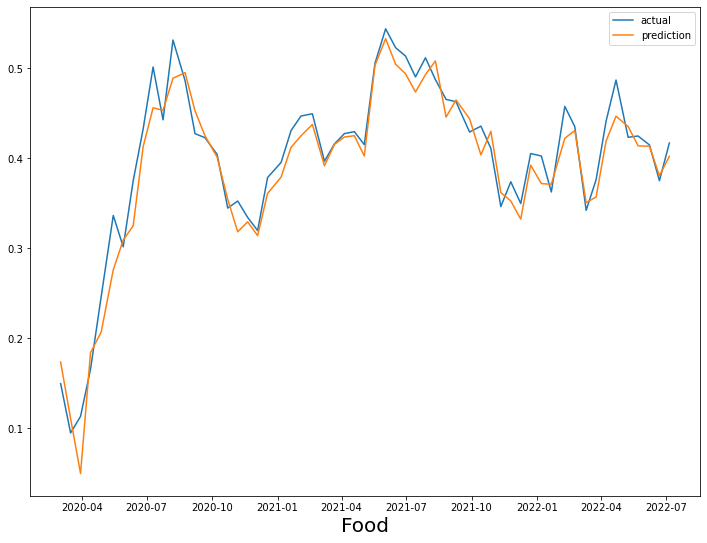

59/59 [==============================] - 1s 2ms/step
Clothing의 test_data의 출력 크기 :  (59, 1)


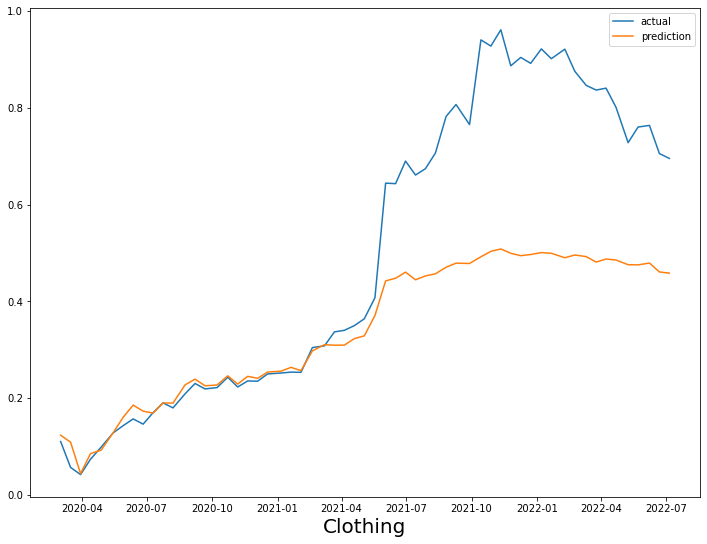

59/59 [==============================] - 1s 2ms/step
Chemical의 test_data의 출력 크기 :  (59, 1)


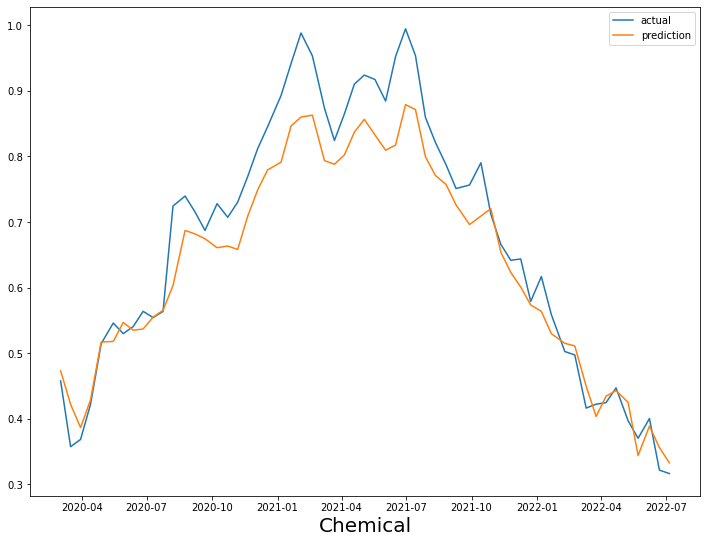

59/59 [==============================] - 1s 2ms/step
Medicine의 test_data의 출력 크기 :  (59, 1)


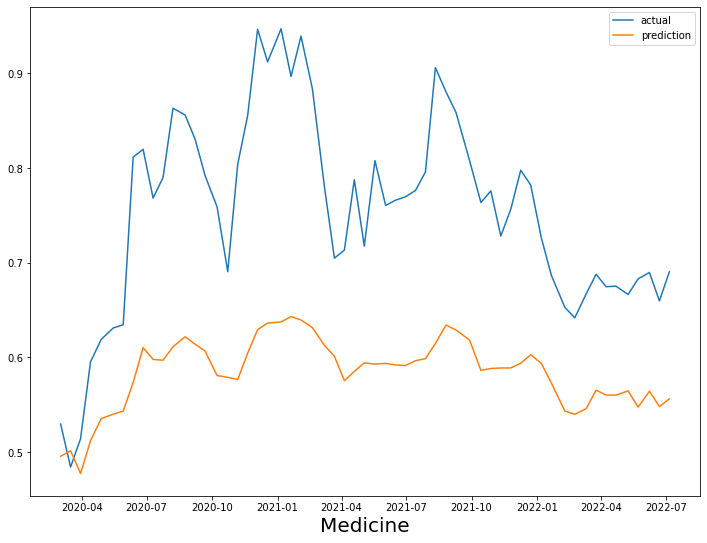

59/59 [==============================] - 1s 2ms/step
Non_Metal의 test_data의 출력 크기 :  (59, 1)


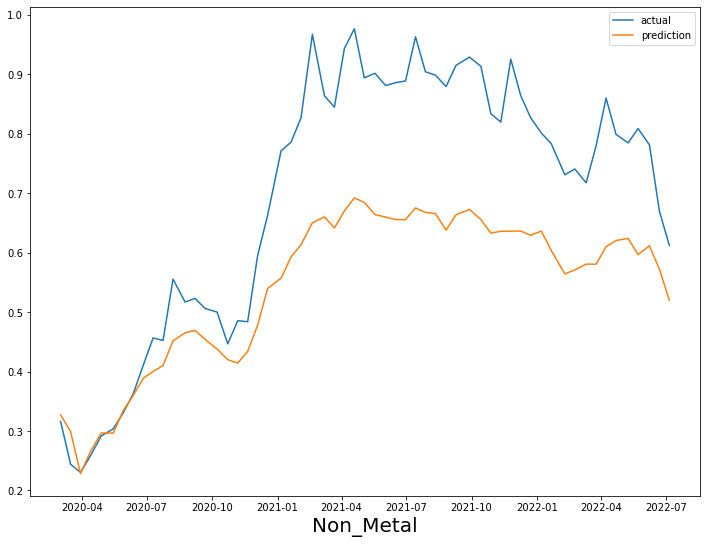

59/59 [==============================] - 1s 2ms/step
Metal의 test_data의 출력 크기 :  (59, 1)


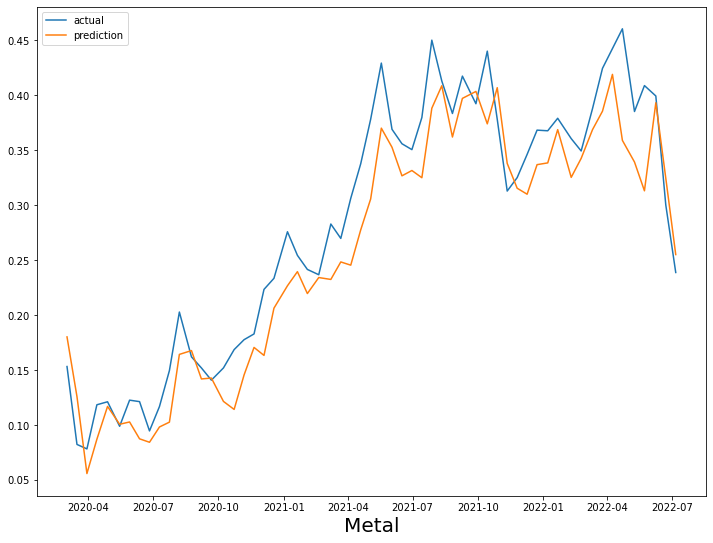

59/59 [==============================] - 1s 2ms/step
Machine의 test_data의 출력 크기 :  (59, 1)


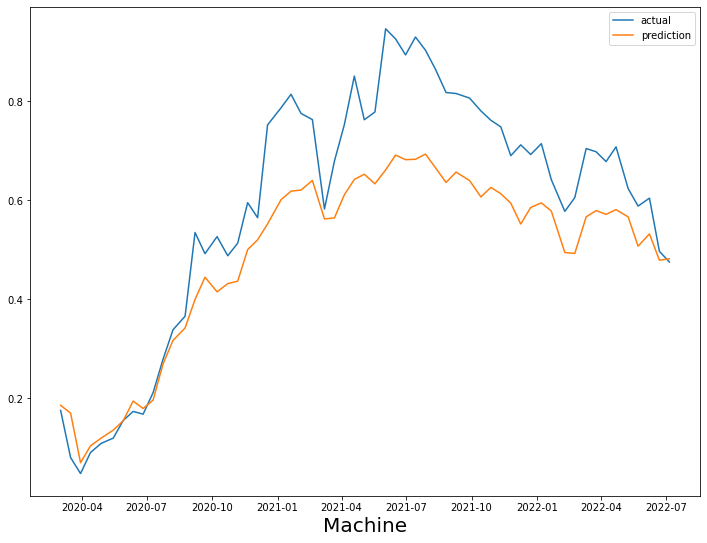

59/59 [==============================] - 1s 2ms/step
Electronic의 test_data의 출력 크기 :  (59, 1)


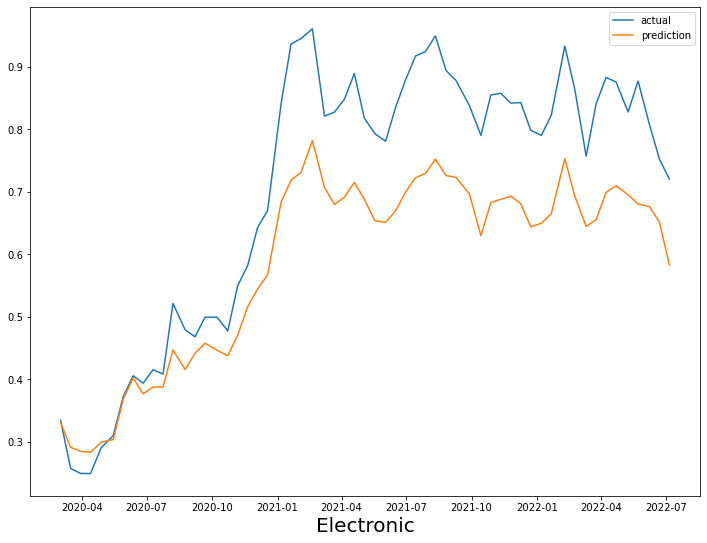

59/59 [==============================] - 1s 2ms/step
Construction의 test_data의 출력 크기 :  (59, 1)


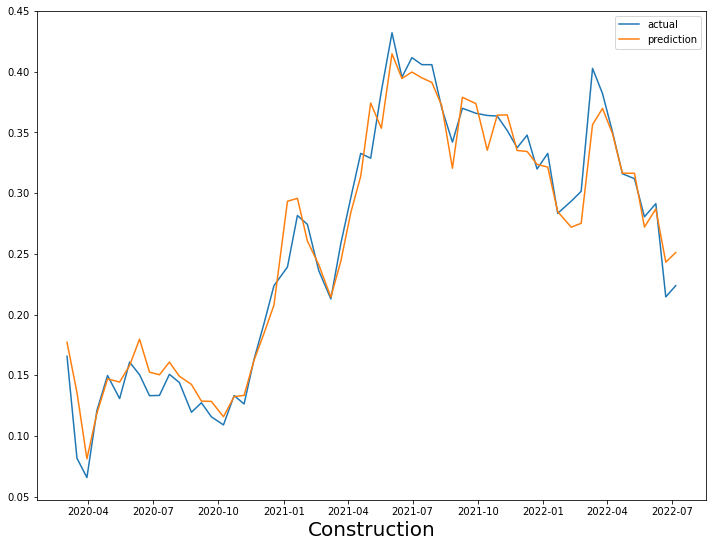

59/59 [==============================] - 1s 2ms/step
Transport의 test_data의 출력 크기 :  (59, 1)


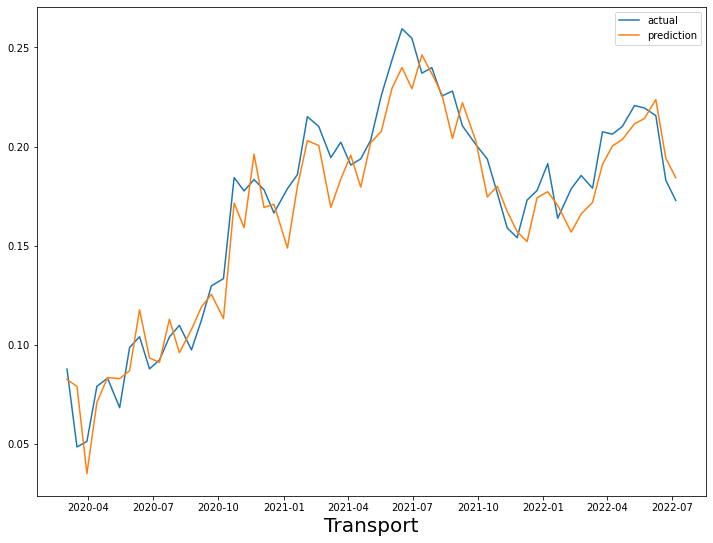

59/59 [==============================] - 1s 2ms/step
Distribution의 test_data의 출력 크기 :  (59, 1)


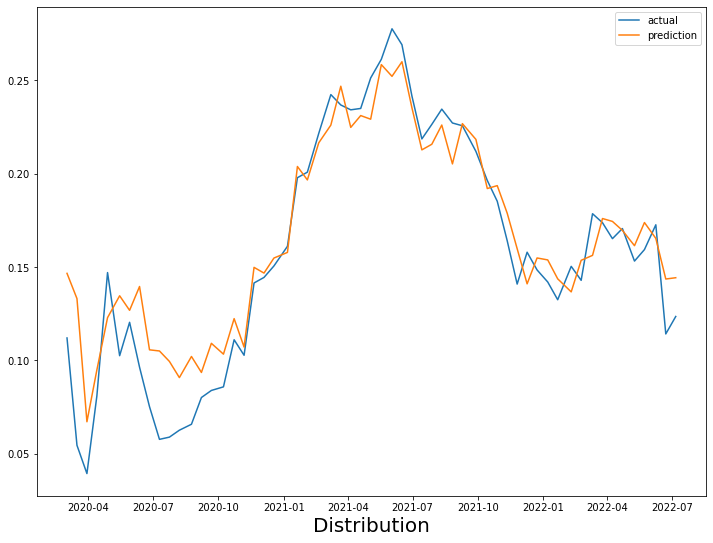

59/59 [==============================] - 1s 2ms/step
Power의 test_data의 출력 크기 :  (59, 1)


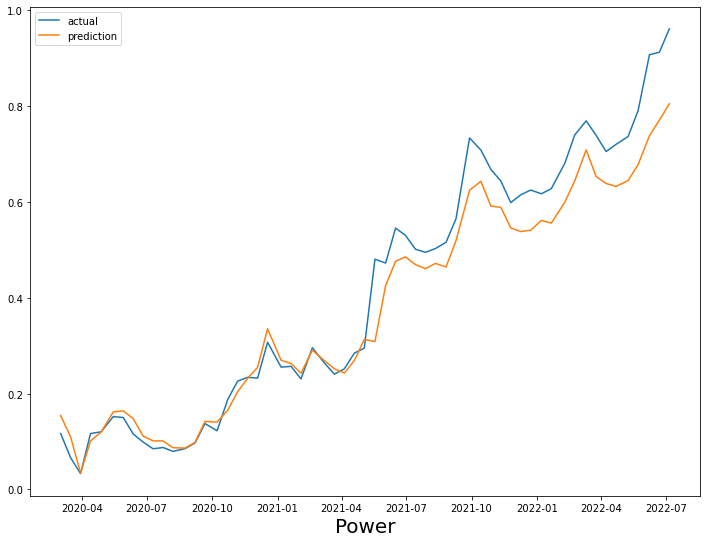

59/59 [==============================] - 1s 2ms/step
Tele의 test_data의 출력 크기 :  (59, 1)


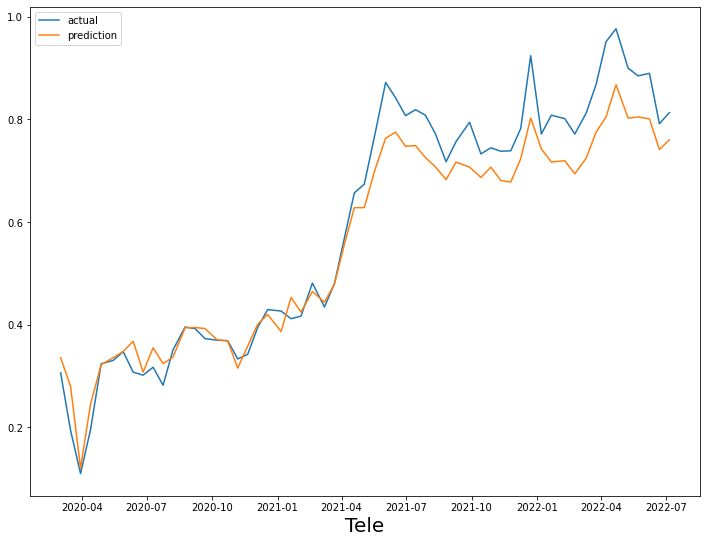

59/59 [==============================] - 1s 2ms/step
Finance의 test_data의 출력 크기 :  (59, 1)


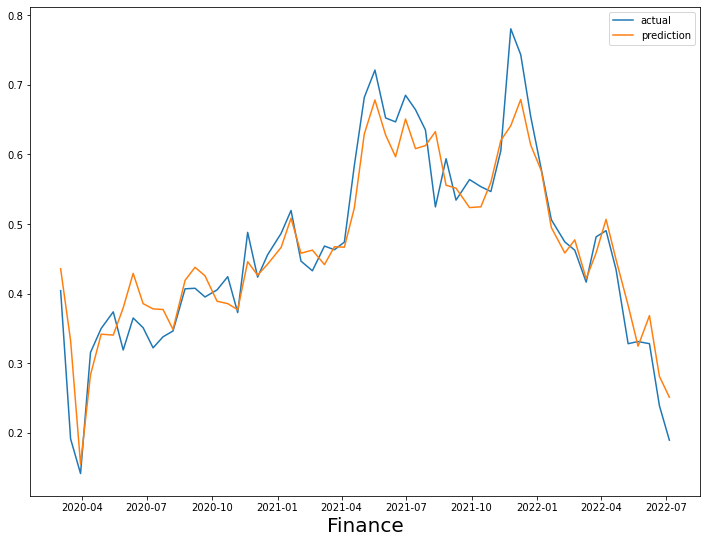

59/59 [==============================] - 1s 2ms/step
Brokerage의 test_data의 출력 크기 :  (59, 1)


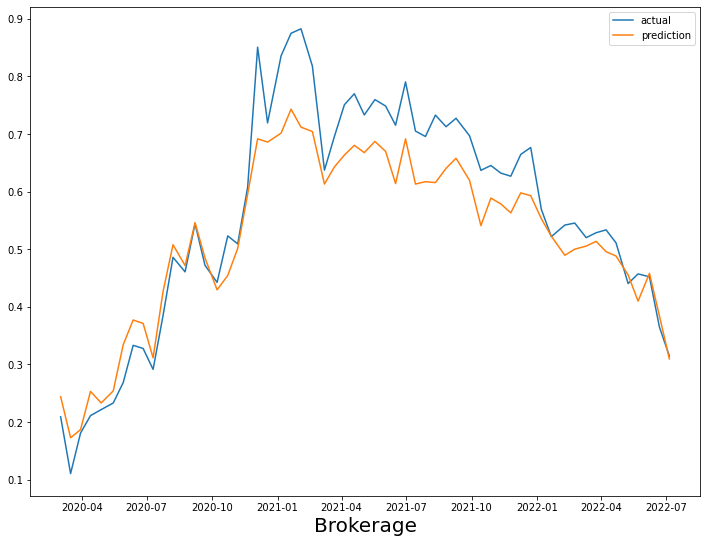

59/59 [==============================] - 1s 2ms/step
Insurer의 test_data의 출력 크기 :  (59, 1)


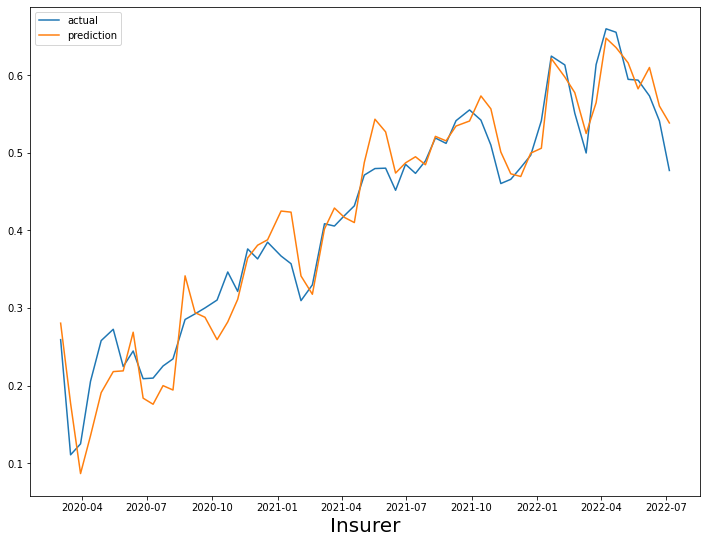

59/59 [==============================] - 1s 2ms/step
Service의 test_data의 출력 크기 :  (59, 1)


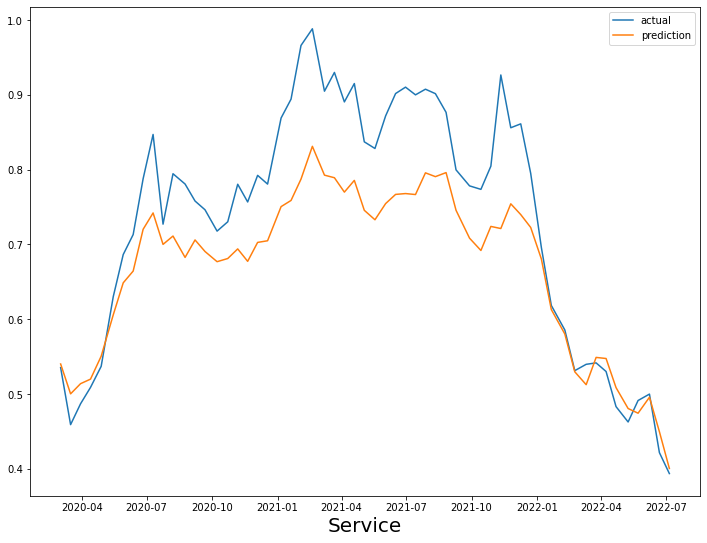

59/59 [==============================] - 1s 2ms/step
Manufacturer의 test_data의 출력 크기 :  (59, 1)


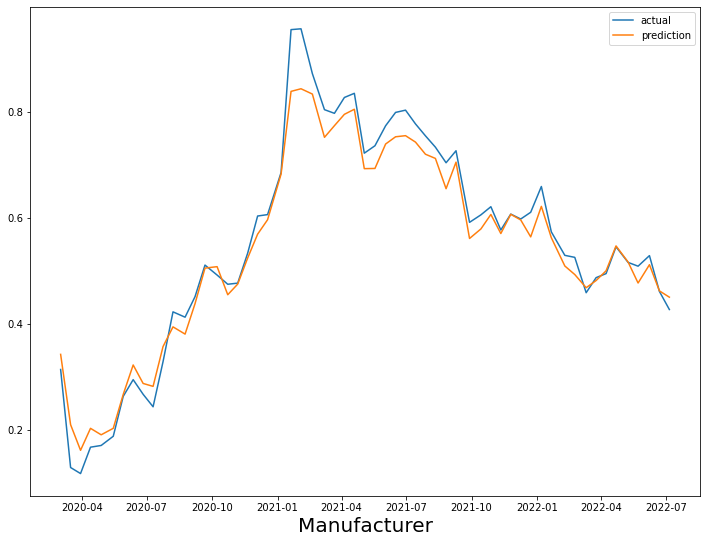

In [17]:
for sector_name, model in model_dic.items():
    df_일자 = (y_test_dic[sector_name].index)[10::10]
    pred = model.predict(tf_dataset_test_dic[sector_name])
    print(f'{sector_name}의 test_data의 출력 크기 : ' ,pred.shape)
    plt.figure(figsize=(12, 9))
    plt.xlabel(sector_name, fontdict={'size': 20})
    plt.plot(df_일자,np.asarray(y_test_dic[sector_name])[10::10], label='actual')
    plt.plot(df_일자,pred, label='prediction')
    plt.legend()
    plt.show()

In [18]:
with open('filename_dic.pickle', 'wb') as f:
    pickle.dump(filename_dic,f)

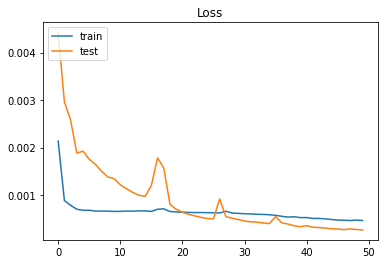

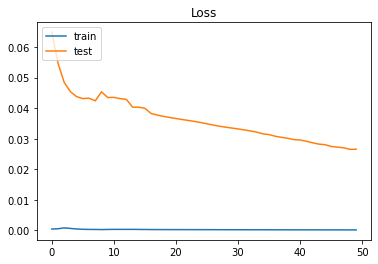

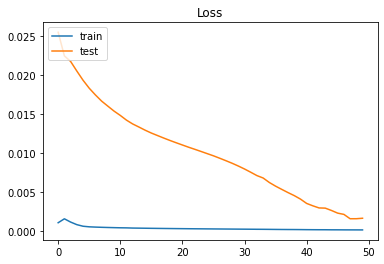

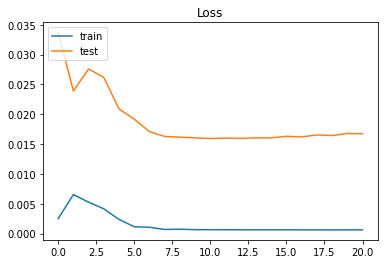

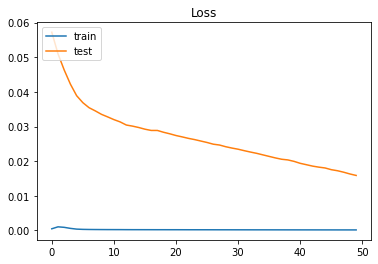

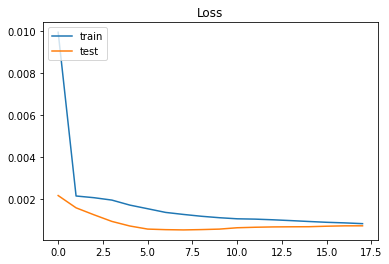

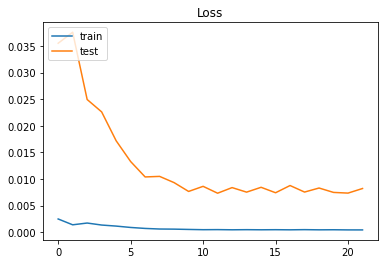

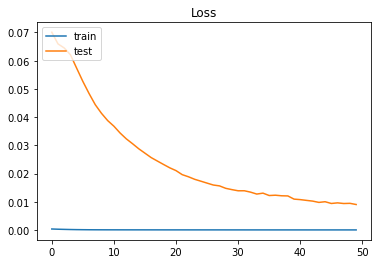

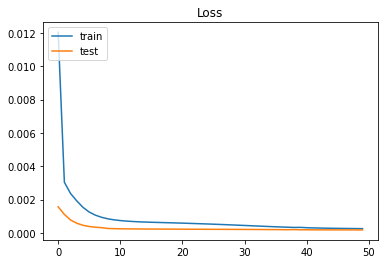

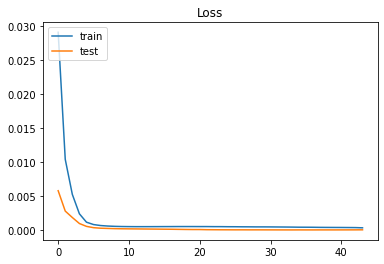

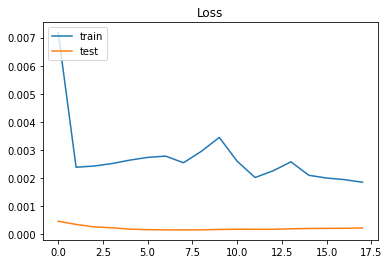

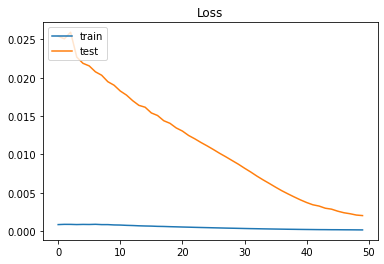

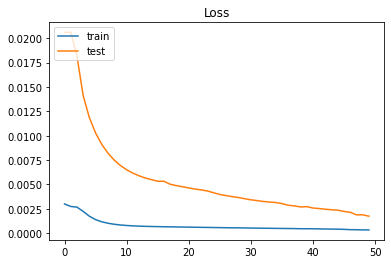

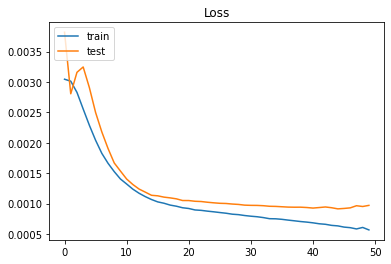

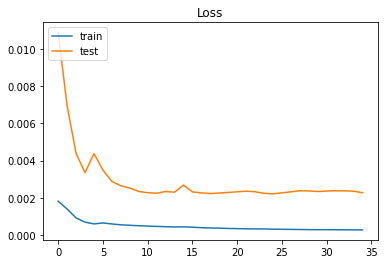

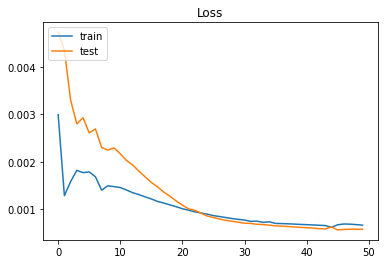

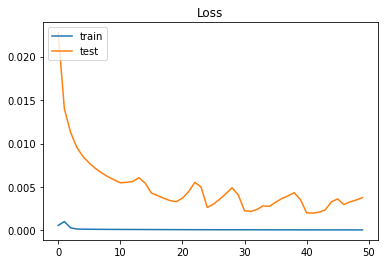

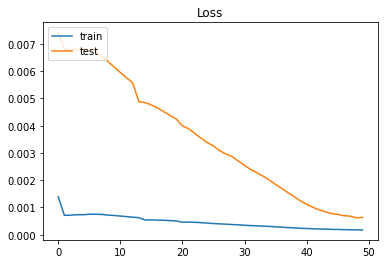

In [22]:
for sector_name, hist in history_dic.items():
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train','test'], loc='upper left')
    plt.show()